# 9. 비지도 학습

비지도 학습 문제에는 클러스터링(clustering),차원압축(dimensionality reduction),이상감지(anomaly detection) 등이 있다.

## 9.1 2차원 입력 데이터
* 클러스터 : 데이터분포의 모양
* 클러스터링 : 데이터 분포에서 클러스터를 찾아, 동일한 클러스터에 속하는 데이터 점에는 같은 클래스(라벨)을 붙이고, 다른 클러스터에 속하는 데이터 점에는 다른 클래스를 할당 하는 것.

=> 동일한 클러스터에 속하는 데이터 점은 '닮았다', 다른 클러스터에 속하는 데이터점은 '닮지않았다'로 볼수 있음   
ex) 고객 데이터(소비금액,구입시간대)를 클러스터링 하면 주부층,직장인층 등의 유형을 가진 고객을 나타내어 클래스별로 판매전략을 만들수 있음   
ex) 곤충데이터(질량과길이,머리크기 등)에 2개의 클러스터가 있다면 데이터에 두가지 변종이 존재할 가능성을 찾아낸다  

* 클래스는 단순한 라벨을 나타내고 클러스터는 분포의 특징을 나타냄


클러스터링에는 다양한 알고리즘이 제안되어 있지만, 가장 많이 사용되는 K-means기법과 가우시안 혼합 모델을 사용한 클러스터링을 설명.

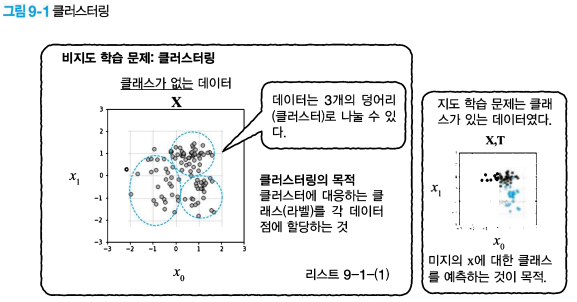


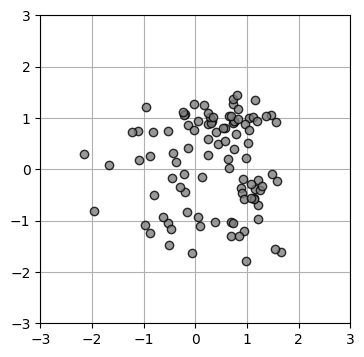

In [ ]:
# ----------------- 리스트 9-1-(1)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# 데이터 생성 --------------------------------
np.random.seed(1)
N = 100
K = 3
T3 = np.zeros((N, 3), dtype=np.uint8)
X = np.zeros((N, 2))
X_range0 = [-3, 3]
X_range1 = [-3, 3]
X_col = ['cornflowerblue', 'black', 'white']
Mu = np.array([[-.5, -.5], [.5, 1.0], [1, -.5]]) # 분포의 중심
Sig = np.array([[.7, .7], [.8, .3], [.3, .8]]) # 분포의 분산
Pi = np.array([0.4, 0.8, 1]) # 누적 확률
for n in range(N):
    wk = np.random.rand()
    for k in range(K):
        if wk < Pi[k]:
            T3[n, k] = 1
            break
    for k in range(2):
        X[n, k] = (np.random.randn() * Sig[T3[n, :] == 1, k]
                   + Mu[T3[n, :] == 1, k])


# 데이터를 그리기 ------------------------------
def show_data(x):
    plt.plot(x[:, 0], x[:, 1], linestyle='none',
             marker='o', markersize=6,
             markeredgecolor='black', color='gray', alpha=0.8)
    plt.grid(True)


# 메인 ------------------------------------
plt.figure(1, figsize=(4, 4))
show_data(X)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.show()
np.savez('data_ch9.npz', X=X, X_range0=X_range0,
         X_range1=X_range1)

## 9.2 K-means 기법
### 9.2.1 K-means 기법의 개요

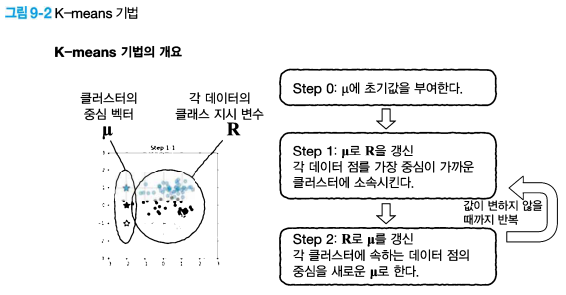

분할 할 클러스터 수 K를 결정해야하는데 여기서는 K=3 개의 클러스터로 분류한다.

K-means 기법에는 두 변수를 사용한다.   
μ : 클러스터의 중심 벡터로 클러스터의 중심 위치를 나타낸다.   
R : 클래스 지시변수로 각 데이터 점이 어떤 클러스터에 속하는지 나타낸다.

* Step 0 : 클러스터의 중심벡터 μ에 적절한 값을 제공
* Stpe 1 : 현시점에서 클러스터 중심벡터 μ를 바탕으로, 클래스 지시변수 R 결정
* Step 2 : 현시점에서 클래스 지시변수 R로 μ를 갱신
* Step 1과 Step 2를 반복하며 μ와 R의 갱신을 계속하고 값이 변하지 않게 되면 종료한다.

### 9.2.2 Step 0 : 변수의 준비와 초기화
k 번째 클러스터 중심벡터 μ는 아래와 같다.
image.png

입력 차원이 2 차원이므로 클러스터 중심도 2차원 벡터이고
이 예에서 K=3이므로    
image.png   
로 정한다.

클래스 지시변수 R은 각 데이터가 어디에 속해 있는지 1-of-K 부호화 법으로 나탄 행렬로 성분은 아래와 같다
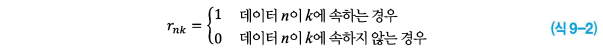

데이터 n에 대한 R을 벡터로 나타내면 클래스 0에 속하는 경우는 다음 과 같고
image.png

모든 데이터를 정리해 행렬로 나타낸 R은 아래와 같다.
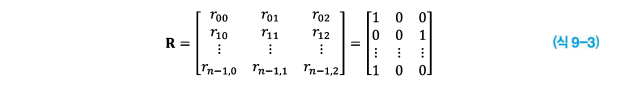

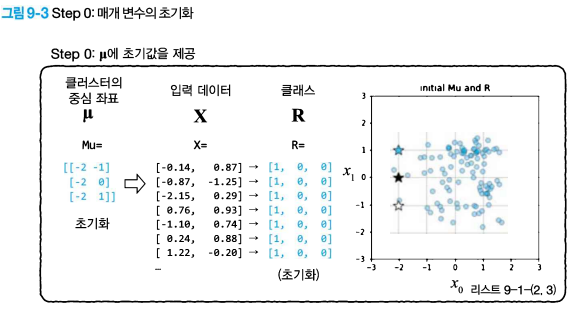

In [ ]:
# ----------------- 리스트 9-1-(2)
# Mu 및 R 초기화 -----------------------------
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]]) # (A) 3개의 μ를 한 덩어리로 묶은 3x2 행렬
R = np.c_[np.ones((N, 1), dtype=int), np.zeros((N, 2), dtype=int)] # (B) 0클래스에 속하도록 초기화 했지만 어떻게 초기화 하든 상관 x

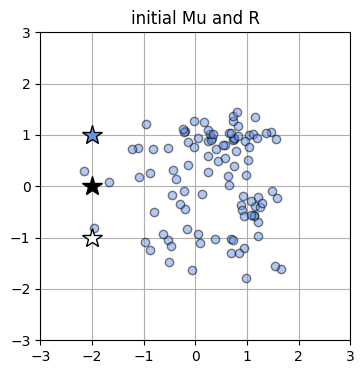

In [ ]:
# ----------------- 리스트 9-1-(3)
# 데이터를 그리는 함수 ---------------------------
def show_prm(x, r, mu, col):
    for k in range(K):
        # 데이터 분포의 묘사
        plt.plot(x[r[:, k] == 1, 0], x[r[:, k] == 1, 1],
                 marker='o',
                 markerfacecolor=X_col[k], markeredgecolor='k',
                 markersize=6, alpha=0.5, linestyle='none')
        # 데이터의 평균을 "별표"로 묘사
        plt.plot(mu[k, 0], mu[k, 1], marker='*',
                 markerfacecolor=X_col[k], markersize=15,
                 markeredgecolor='k', markeredgewidth=1)
    plt.xlim(X_range0)
    plt.ylim(X_range1)
    plt.grid(True)


# ------------------------------
plt.figure(figsize=(4, 4))
R = np.c_[np.ones((N, 1)), np.zeros((N, 2))]
show_prm(X, R, Mu, X_col)
plt.title('initial Mu and R')
plt.show()

### 9.2.3 Step 1 : R의 갱신

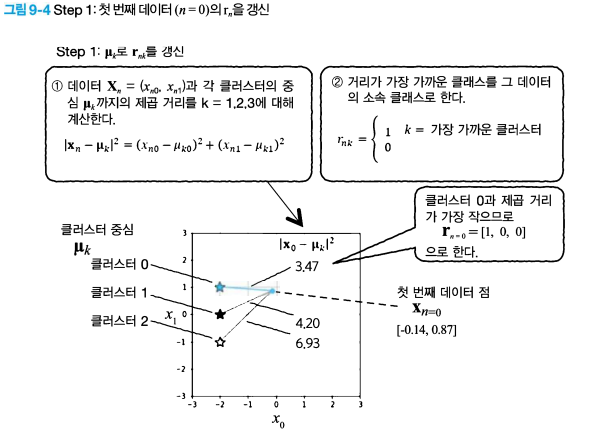   
R을 갱신할때엔 "각 데이터점을 가장 중심이 가까운 클러스터에 넣는다"에 따라 갱신한다.   
첫번째(n=0) 데이터점 [-0.14,0.87]에서 클러스터 중심까지의 제곱 거리를 각 클러스터에 대해 계산하면
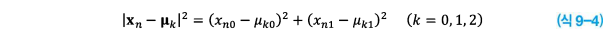   
에 따라 클러스터 0,1,2까지 제곱거리는 3.47,4.20,6.93 이 되어 클러스터 0이 가장 거리가 가까우므로 r(n=0) = [1,0,0] 이 되는 것이다.
이를 모든 데이터에 수행하고 나면 모든 데이터 점들이 각 클레스에 배정 된다.
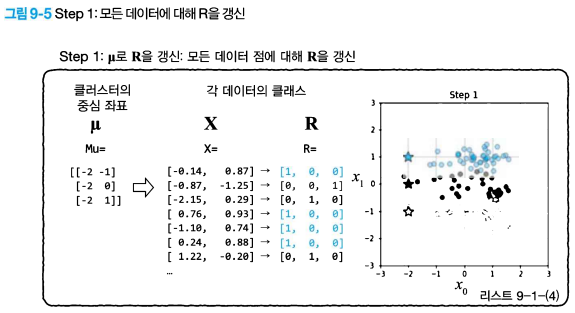


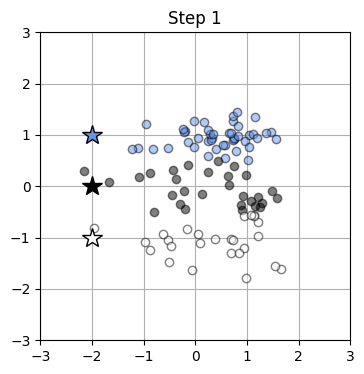

In [ ]:
# ----------------- 리스트 9-1-(4)
# r을 결정한다 (Step 1) -----------
def step1_kmeans(x0, x1, mu):
    N = len(x0)
    r = np.zeros((N, K))
    for n in range(N):
        wk = np.zeros(K)
        for k in range(K):
            wk[k] = (x0[n] - mu[k, 0])**2 + (x1[n] - mu[k, 1])**2
        r[n, np.argmin(wk)] = 1
    return r


# ------------------------------
plt.figure(figsize=(4, 4))
R = step1_kmeans(X[:, 0], X[:, 1], Mu)
show_prm(X, R, Mu, X_col)
plt.title('Step 1')
plt.show()

### 9.2.4 Step 2 : μ의 갱신

μ를 갱신할때엔 "각 클러스터에 속하는 데이터 점의 중심을 새로운 μ로 한다"에 따라 갱신한다.


k=0에 속하는 데이터 rn=[1,0,0]의 라벨을 가진 데이터점에 주목해 각 평균을 구한다.
같은 방식으로 k=1,k=2에 대해 실시하면 Step2는 끝이난다.   
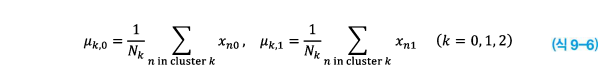

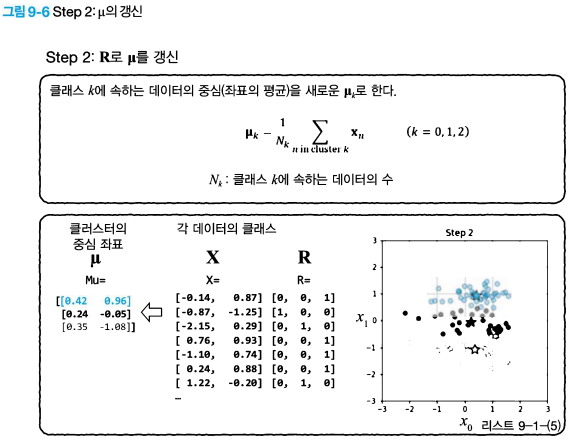

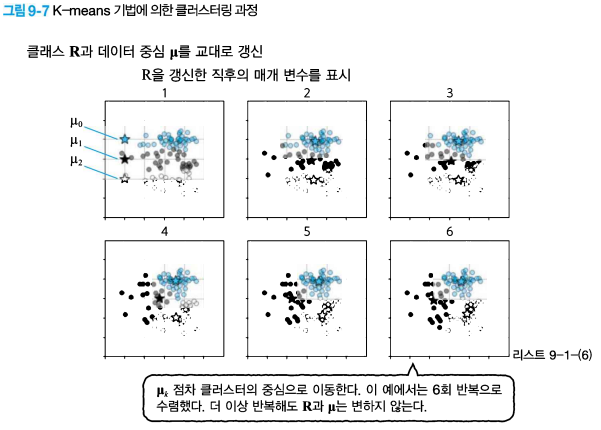

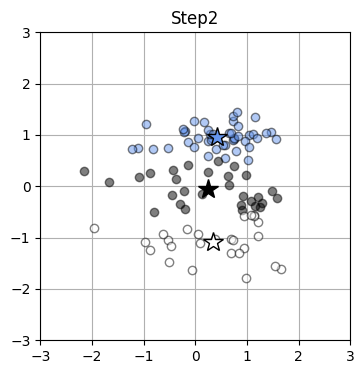

In [ ]:
# ----------------- 리스트 9-1-(5)
# Mu 결정 (Step 2) ----------
def step2_kmeans(x0, x1, r):
    mu = np.zeros((K, 2))
    for k in range(K):
        mu[k, 0] = np.sum(r[:, k] * x0) / np.sum(r[:, k])
        mu[k, 1] = np.sum(r[:, k] * x1) / np.sum(r[:, k])
    return mu


# ------------------------------
plt.figure(figsize=(4, 4))
Mu = step2_kmeans(X[:, 0], X[:, 1], R)
show_prm(X, R, Mu, X_col)
plt.title('Step2')
plt.show()

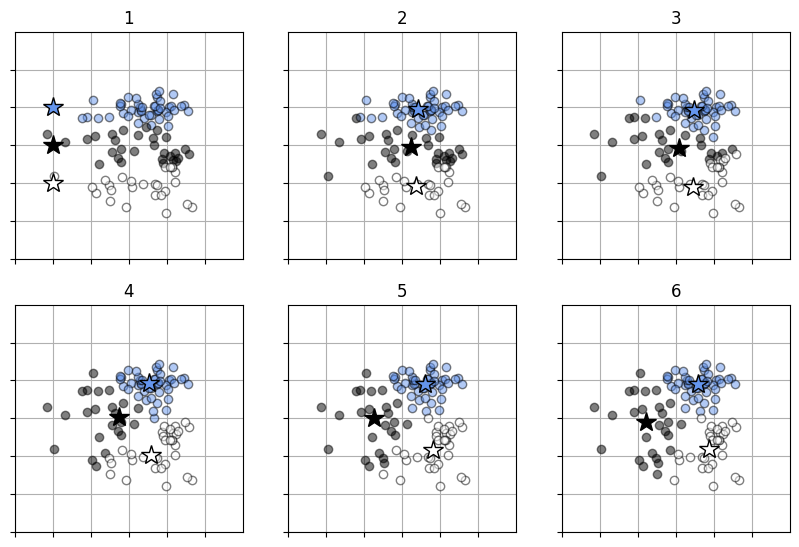

In [ ]:
# ----------------- 리스트 9-1-(6)
plt.figure(1, figsize=(10, 6.5))
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
max_it = 6 # 반복 횟수, 이 예시에서는 6회 반복으로 변화가 멈추었음
for it in range(0, max_it):
    plt.subplot(2, 3, it + 1)
    R = step1_kmeans(X[:, 0], X[:, 1], Mu)
    show_prm(X, R, Mu, X_col)
    plt.title("{0:d}".format(it + 1))
    plt.xticks(range(X_range0[0], X_range0[1]), "")
    plt.yticks(range(X_range1[0], X_range1[1]), "")
    Mu = step2_kmeans(X[:, 0], X[:, 1], R)
plt.show()

### 9.2.5 왜곡 척도

비지도 학습의 오차함수 처럼 학습이 진행됨에 따라 감소하는 목적함수는 없을까?   
K-means의 경우, 데이터 점이 속한 클러스터의 중심까지의 제곱 거리를 전체 데이터로 합친 것이 목적함수(목적을 가지고 모델을 학습해 최적하 하고자하는 함수)에 대응하는데 이를 식으로 표현하면 아래와 같고 왜곡척도(distortion measure)라는 이름이 붙어있다.   
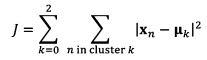

In [ ]:
# ----------------- 리스트 9-1-(7)
# 목적 함수 ----------------------------------
# 왜곡 척도를 계산하는 함수
def distortion_measure(x0, x1, r, mu):
    # 입력은 2차원으로 제한하고 있다
    N = len(x0)
    J = 0
    for n in range(N):
        for k in range(K):
            J = J + r[n, k] * ((x0[n] - mu[k, 0])**2
                               + (x1[n] - mu[k, 1])**2)
    return J


# ---- test
# ---- Mu와 R의 초기화
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
R = np.c_[np.ones((N, 1), dtype=int), np.zeros((N, 2), dtype=int)]
distortion_measure(X[:, 0], X[:, 1], R, Mu)

#output 771.70~~~ 어쩌고는 초기값의 왜곡 척도

771.7091170334878

K-means기법의 반복에 의한 왜곡 척도를 계산한것을 보면 아래 그림과 같은데 점점 감소하여 6회째에 46.86으로 수렴한것을 볼수있다. 이는 더이상 μ와 R값이 변화하지 않는 것을 의미한다.    
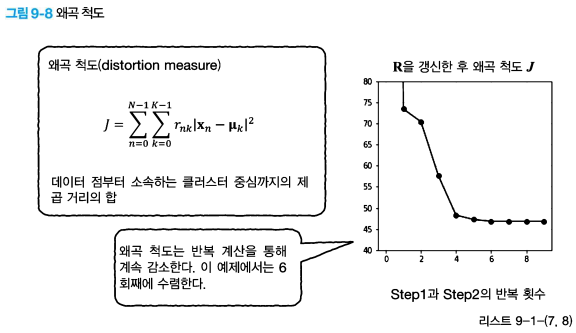

[627.54  73.39  70.39  57.59  48.31  47.28  46.86  46.86  46.86  46.86]


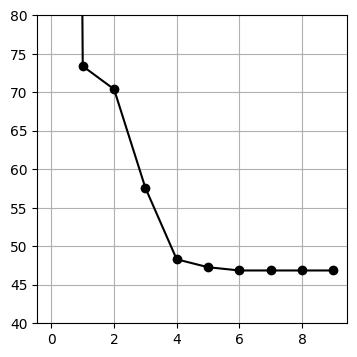

In [ ]:
# ----------------- 리스트 9-1-(8) k-means 반복 왜곡척도 계산
# Mu와 R의 초기화
N=X.shape[0]
K=3
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
R = np.c_[np.ones((N, 1), dtype=int), np.zeros((N, 2), dtype=int)]
max_it = 10
it = 0
DM = np.zeros(max_it) # 왜곡 척도의 계산 결과를 넣는다
for it in range(0, max_it): # K-means 법
    R = step1_kmeans(X[:, 0], X[:, 1], Mu)
    DM[it] = distortion_measure(X[:, 0], X[:, 1], R, Mu) # 왜곡 척도
    Mu = step2_kmeans(X[:, 0], X[:, 1], R)
print(np.round(DM, 2))
plt.figure(2, figsize=(4, 4))
plt.plot(DM, color='black', linestyle='-', marker='o')
plt.ylim(40, 80)
plt.grid(True)
plt.show()

## 9.3 가우시안 혼합 모델

### 9.3.1 확률적 클러스터링
K-means 기법은 데이터 점을 반드시 클러스터에 할당한다.
'데이터 점 A는 클러스터 0에 속하지만, 데이터 점 B는 클러스터0과 클러스터 1에 모두 속해있다'는 모호성을 포함해 수치화 하려면 어떻게 해야할까?   
**확률** 개념을 도입하는 것이다.


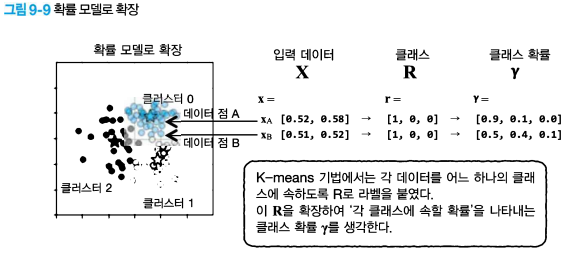

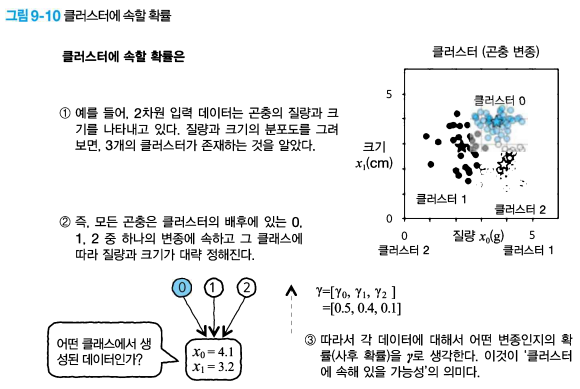

2차원 입력데이터 x= [x0,x1]는 곤충의 질량과 크기를 나타내고 있다고 했을때 '같은 종류의 곤충'이라 생각하고 200마리를 모아 플롯했을때 3개의 클러스터가 나타났다고 하자.   
이때 종류는 같아도 '적어도 3가지의 변종이 있다'라고 해석할수 있고 어떤 변종인지에 따라 질량과 크기가 정해진다고 생각할수 있다.
이렇게 관찰은 못했지만 영향을 준 변수를 **잠재변수** 또는 숨은변수(hidden variable)이라고 한다.   
이 잠재 변수를 3차원 벡터를 사용하여 1-of-K 부호화법으로 표현하면 아래와 같다.   
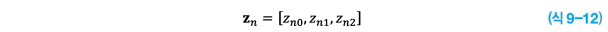   
데이터 n이 클래스 k에 속한다면 znk만 1을 취하고 다른요소는 0이된다.   
이 관점에서 데이터 n이 클러스터k에 속할 확률ynk란 데이터xn인 곤충이 '클래스 k의 변종일 확률'을 의미한다.
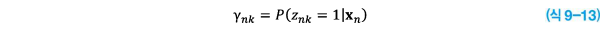   
"관찰할 수 없는 Z의 추정치가 γ다" 라 말할수있고 Z는 "어떤 클래스에 속하고있는가", γ는 "어떤 클러스터에 얼마나 기여하고 있는가"라는 의미에서 **부담률(responsibility)**라고 한다.

**확률적 클러스터링은 데이터의 배후에 숨어 있는 잠재변수 Z를 확률적으로 γ로 추정하는 것**이다.라고 정리할수 있다.

### 9.3.2 가우시안 혼합 모델

부담률 γ를 구하기 위해 가우시안 혼합 모델을 소개한다.   
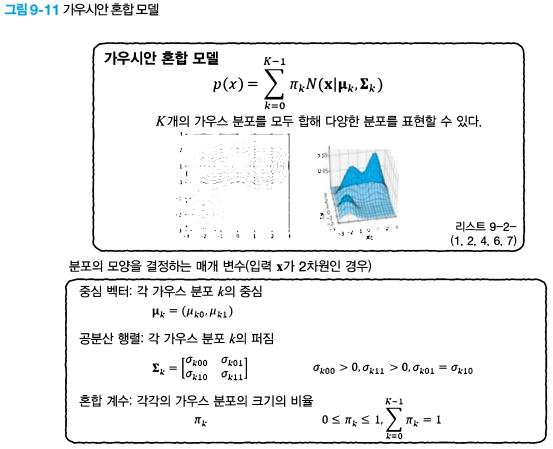

가우시안 혼합 모델은 2차원 가우스 함수를 여러개 합친 것으로 아래의 식과 같다.   
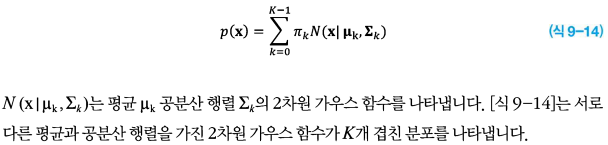

모델의 매개변수는
* μk : 각 가우스 분포의 중심을 나타내는 중심 벡터
* Σk : 분포의 퍼짐을 나타내는 공분산 행렬
* πk : 가우스 분포의 크기의 비율을 나타내는 혼합계수(0~1 사이 실수, 총 합은 1

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
# ----------------- 리스트 9-2-(1)
import numpy as np
wk = np.load('data_ch9.npz')
X = wk['X']
X_range0 = wk['X_range0']
X_range1 = wk['X_range1']

In [ ]:
# ----------------- 리스트 9-2-(2)
# 가우스 함수 -----------------------------
def gauss(x, mu, sigma):
    # x : NxD 데이터 행렬, mu : 길이 D인 중심벡터, sigma : DxD의 공분산행렬

    N, D = x.shape
    c1 = 1 / (2 * np.pi)**(D / 2)
    c2 = 1 / (np.linalg.det(sigma)**(1 / 2))
    inv_sigma = np.linalg.inv(sigma)
    c3 = x - mu
    c4 = np.dot(c3, inv_sigma)
    c5 = np.zeros(N)
    for d in range(D):
        c5 = c5 + c4[:, d] * c3[:, d]
    p = c1 * c2 * np.exp(-c5 / 2)
    return p

In [ ]:
# ----------------- 리스트 9-2-(3)
x = np.array([[1, 2], [2, 1], [3, 4]])
mu = np.array([1, 2])
sigma = np.array([[1, 0], [0, 1]])
print(gauss(x, mu, sigma))

[0.15915494 0.05854983 0.00291502]


In [ ]:
# ----------------- 리스트 9-2-(4)
# 혼합 가우시안 모델 ----------------------
def mixgauss(x, pi, mu, sigma):
    # x : NxD 행렬, pi : 혼합계수, 길이 K의 벡터,
    # mu : 중심벡터, KxD 행렬, K개의 가우스함수의 중심을 지정,
    # sigma : KxDxD의 3차원 배열 변수로 K개의 가우스 함수의 공분산 행렬을 한꺼번에 지정

    N, D = x.shape
    K = len(pi)
    p = np.zeros(N)
    for k in range(K):
        p = p + pi[k] * gauss(x, mu[k, :], sigma[k, :, :])
    return p

In [ ]:
# ------------ 리스트 9-2-(5)
# test -------------------------------
x = np.array([[1, 2], [2, 2], [3, 4]])
pi = np.array([0.3, 0.7])
mu = np.array([[1, 1], [2, 2]])
sigma = np.array([[[1, 0], [0, 1]], [[2, 0], [0, 1]]])
print(mixgauss(x, pi, mu, sigma))

[0.09031182 0.09634263 0.00837489]


In [ ]:
# ----------------- 리스트 9-2-(6)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
#%matplotlib inline
# 혼합 가우스 등고선 표시 ----------------------
def show_contour_mixgauss(pi, mu, sigma):
    xn = 40 # 등고선 표시 해상도
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    x = np.c_[np.reshape(xx0, (xn * xn, 1)), np.reshape(xx1,( xn * xn, 1))]
    f = mixgauss(x, pi, mu, sigma)
    f = f.reshape(xn, xn)
    f = f.T
    plt.contour(x0, x1, f, 10, colors='gray')


# 혼합 가우스 3D 표시 ---------------------------
def show3d_mixgauss(ax, pi, mu, sigma):
    xn = 40 # 등고선 표시 해상도
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    x = np.c_[np.reshape(xx0, (xn * xn, 1)), np.reshape(xx1, (xn * xn, 1))]
    f = mixgauss(x, pi, mu, sigma)
    f = f.reshape(xn, xn)
    f = f.T
    ax.plot_surface(xx0, xx1, f, rstride=2, cstride=2, alpha=0.3,
                    color='blue', edgecolor='black')

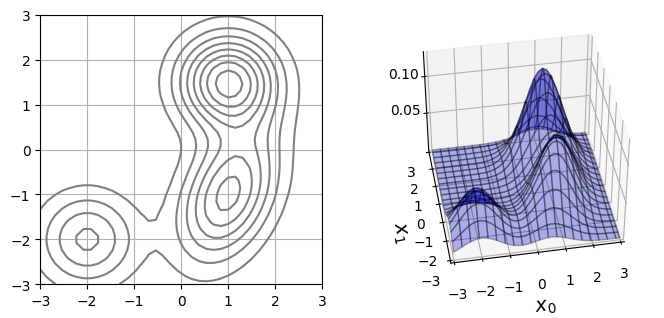

In [ ]:
# ------------ 리스트 9-2-(7)
# test -----------------------------------
pi = np.array([0.2, 0.4, 0.4])
mu = np.array([[-2, -2], [-1, 1], [1.5, 1]])
sigma = np.array(
    [[[.5, 0], [0, .5]], [[1, 0.25], [0.25, .5]], [[.5, 0], [0, .5]]])


Fig = plt.figure(1, figsize=(8, 3.5))
Fig.add_subplot(1, 2, 1)
show_contour_mixgauss(pi, mu, sigma)
plt.grid(True)


Ax = Fig.add_subplot(1, 2, 2, projection='3d')
show3d_mixgauss(Ax, pi, mu, sigma)
Ax.set_zticks([0.05, 0.10])
Ax.set_xlabel('$x_0$', fontsize=14)
Ax.set_ylabel('$x_1$', fontsize=14)
Ax.view_init(40, -100)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.show()

### 9.3.3 EM 알고리즘의 개요

가우시안 혼합 모델을 사용하여 데이터의 클러스터링을 수행하는데 여기서는 EM알고리즘을 사용해 가우시안 혼합모델을 피팅하고 부담률 γ를 구하는 방법을 설명한다.

K-means 기법에서는 각 클러스터를 중심벡터μ로 특정했지만, 가우시안 혼합 모델은 중심벡터μ뿐만 아니라 공분산 행렬Σ에 의해 각 클러스터의 크기 차이를 설명한다.   
클러스터링의 출력은
* k-means 에서는 R
* 가우시안 혼합 모델은 각 클래스에 속할 확률에 대응하는 부담률 γ

이다.

* Step 0 : π,μ,Σ 초기화 (초기값 부여)
* Step 1(E Step) : 현시점의 π,μ,Σ를 사용해 부담률γ를 구함
* Step 2 (M Step) : 현시점의 γ를 사용해 π,μ,Σ를 구함
* Step 1과 Step2를 매개변수가 수렴할때까지 반복


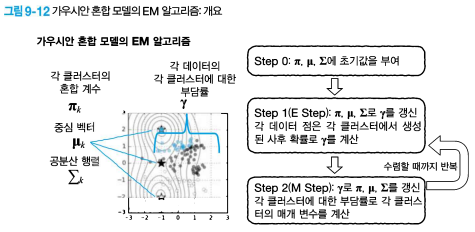

### 9.3.4 Step0 : 변수의 준비 및 초기화

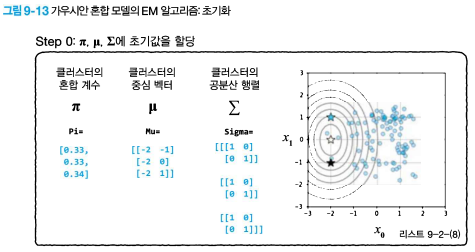

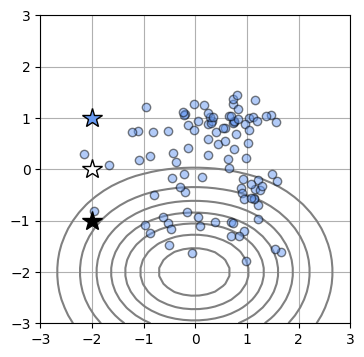

In [ ]:
# ----------------- 리스트 9-2-(8)
# 초기 설정 ------------------------------------
N = X.shape[0]
K = 3
Pi = np.array([0.33, 0.33, 0.34])
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]


X_col=np.array([[0.4, 0.6, 0.95], [1, 1, 1], [0, 0, 0]])


# 데이터를 그리기 ------------------------------
def show_mixgauss_prm(x, gamma, pi, mu, sigma):
    N, D = x.shape
    show_contour_mixgauss(pi, mu, sigma)
    for n in range(N):
        col=gamma[n,0]*X_col[0]+gamma[n,1]*X_col[1]+gamma[n,2]*X_col[2]
        plt.plot(x[n, 0], x[n, 1], 'o',
                 color=tuple(col), markeredgecolor='black',
                 markersize=6, alpha=0.5)
    for k in range(K):
        plt.plot(mu[k, 0], mu[k, 1], marker='*',
                 markerfacecolor=tuple(X_col[k]), markersize=15,
                 markeredgecolor='k', markeredgewidth=1)


    plt.grid(True)


plt.figure(1, figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

### 9.3.5 Step 1(E Step) : γ갱신

'가우스 함수의 값이 높을 수록 부담률도 높아진다'

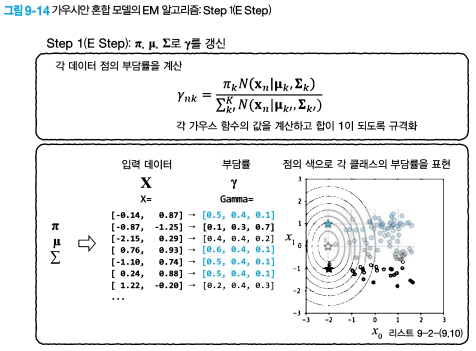

부담률γ를 모든 n과k에 대해 갱신한다.   
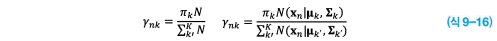

In [ ]:
# ----------------- 리스트 9-2-(9)
# gamma 갱신 (E Step) -------------------
def e_step_mixgauss(x, pi, mu, sigma):
    N, D = x.shape
    K = len(pi)
    y = np.zeros((N, K))
    for k in range(K):
        y[:, k] = gauss(x, mu[k, :], sigma[k, :, :]) # KxN
    gamma = np.zeros((N, K))
    for n in range(N):
        wk = np.zeros(K)
        for k in range(K):
            wk[k] = pi[k] * y[n, k]
        gamma[n, :] = wk / np.sum(wk)
    return gamma


# 메인 ----------------------------------
Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)

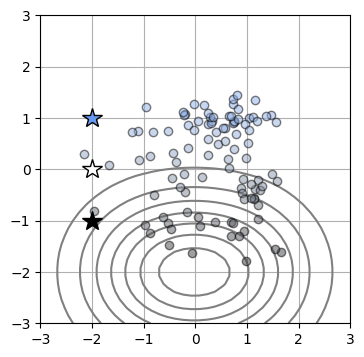

In [ ]:
# -------------- 리스트 9-2-(10)
# 표시 ----------------------------------
plt.figure(1, figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

### 9.3.6 Step 2(M Step) : π,μ,Σ의 갱신
각 클러스터에 대한 부담률의 합 Nk를 구한다. 이는 k-means 기법에서 말하는 각 클러스터에 속할 데이터의 수에 해당한다.   
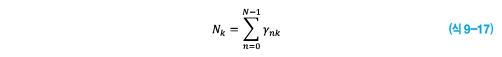

Ynk를 바탕으로 혼합률 πk를 갱신한다.
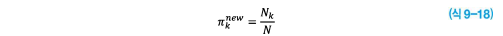

N은 전체 데이터 수이므로 혼합률은 전체에 대한 클러스터 내 수의 비율이 되는, 적합한 갱신식이다.   
중심백터 μk를 아래 처럼 갱신한다.   
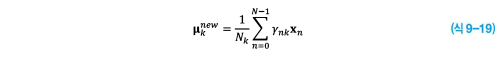

위의 식은 클러스터 부담률의 가중치를 더한 데이터의 평균이다. 마지막으로, 가우스의 공분산 행렬을 갱신한다.
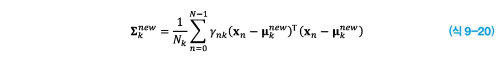   
위의 식은 클러스터에 부담률의 가중치를 더한 데이터의 공분산 행렬을 구하는 것이다.   

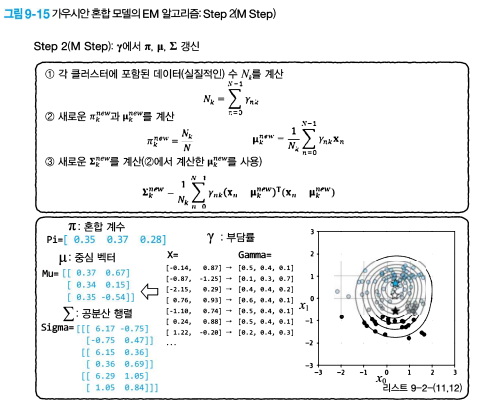

중심벡터를 나타내는 별표가 훨씬 더 클러스터의 중심으로 이동한 것을 볼수 있다.


In [ ]:
# ----------------- 리스트 9-2-(11)
# Pi, Mu, Sigma 갱신 (M step) ------------
def m_step_mixgauss(x, gamma):
    N, D = x.shape
    N, K = gamma.shape
    # pi를 계산
    pi = np.sum(gamma, axis=0) / N
    # mu을 계산
    mu = np.zeros((K, D))
    for k in range(K):
        for d in range(D):
            mu[k, d] = np.dot(gamma[:, k], x[:, d]) / np.sum(gamma[:, k])
    # sigma를 계산
    sigma = np.zeros((K, D, D))
    for k in range(K):
        for n in range(N):
            wk = x - mu[k, :]
            wk = wk[n, :, np.newaxis]
            sigma[k, :, :] = sigma[k, :, :] + gamma[n, k] * np.dot(wk, wk.T)
        sigma[k, :, :] = sigma[k, :, :] / np.sum(gamma[:, k])
    return pi, mu, sigma


# 메인 ----------------------------------
Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)

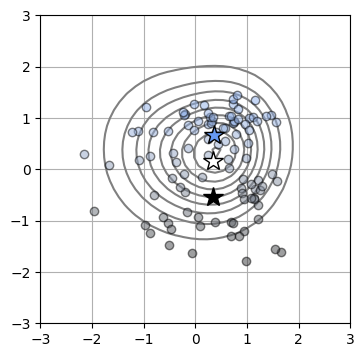

In [ ]:
# ----------------- 리스트 9-2-(12)
# 표시 ----------------------------------
plt.figure(1, figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

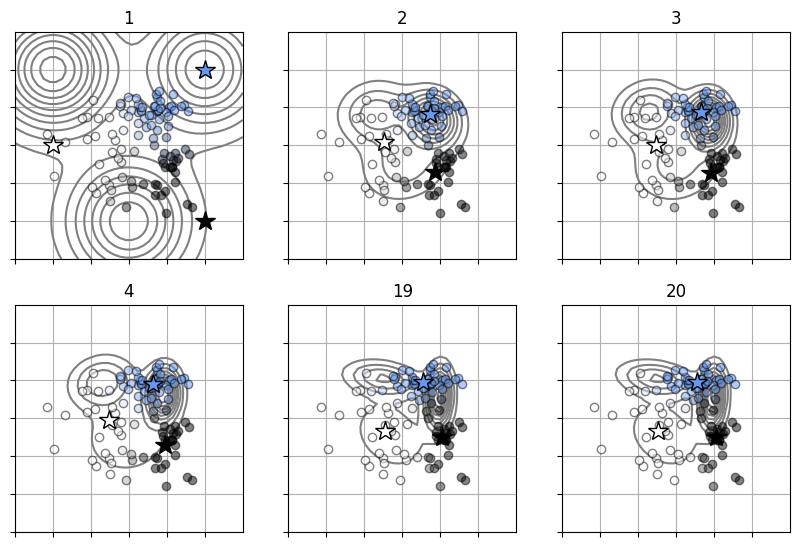

In [ ]:
# ----------------- 리스트 9-2-(13)
Pi = np.array([0.3, 0.3, 0.4])
Mu = np.array([[2, 2], [-2, 0], [2, -2]])
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]
plt.figure(1, figsize=(10, 6.5))
max_it = 20 # 반복 횟수


i_subplot=1;
for it in range(0, max_it):
    Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)
    if it<4 or it>17:
        plt.subplot(2, 3, i_subplot)
        show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
        plt.title("{0:d}".format(it + 1))
        plt.xticks(range(X_range0[0], X_range0[1]), "")
        plt.yticks(range(X_range1[0], X_range1[1]), "")
        i_subplot=i_subplot+1
    Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)
plt.show()

3개의 가우스 함수는 클러스터의 중심으로 이동해 수렴하고 각 데이터점에서 각 클러스터의 부담률은 그라데이션으로 타나타고 있다.
K-means와 달리 각 데이터의 클러스터에 소속이 되는 부담률이라는 확률로 표현되었다.

파랑,하양,검정 색으로 3개의 클러스터를 나타내고 경계부근에서는 중간적인 색으로 데이터가 표시되는것을 볼수 있다.

* 클러스터링 결과는 k-means기법과 마찬가지로 매개변수의 초기값에 따라 달라진다.   
* 클러스터의 장점을 평가하기 위해 k-means에서는 왜곡 척도를 사용했지만 가우시안 혼합 모델의 경우는 '가능도'를 사용한다.

### 9.3.7 가능도
가능도는 모든 데이터 점X가 모델에서 생성된 확률로 아래와 같다.   
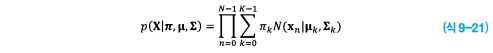

로그를 취한 로그 가능도는 아래와 같다.   
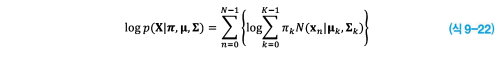   

가능도나 로그가능도를 최적화시킬때는 -1을 곱한 음의 로그가능도를 오차함수E(π,μ,Σ)로 정의한다.   
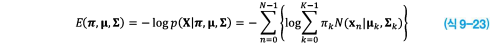   

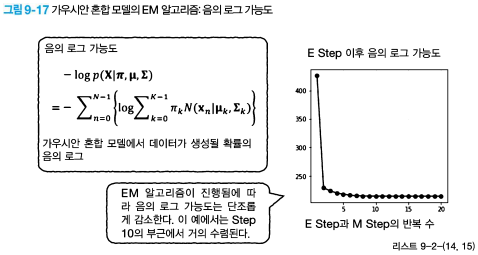

음의 로그 가능도는 Step10정도에서 대부분 수렴한다.   
다양한 클러스터링을 시도하면 가장 좋은 결과는 음의로그 가능도가 가장 작다.

In [ ]:
# ----------------- 리스트 9-2-(14)
# 혼합 가우스의 목적 함수 ----------------------
def nlh_mixgauss(x, pi, mu, sigma):
    # x: NxD
    # pi: Kx1
    # mu: KxD
    # sigma: KxDxD
    # output lh: NxK
    N, D = x.shape
    K = len(pi)
    y = np.zeros((N, K))
    for k in range(K):
        y[:, k] = gauss(x, mu[k, :], sigma[k, :, :]) # KxN
    lh = 0
    for n in range(N):
        wk = 0
        for k in range(K):
            wk = wk + pi[k] * y[n, k]
        lh = lh + np.log(wk)
    return -lh

[426.22 229.86 224.32 220.8  218.63 216.93 215.93 215.51 215.33 215.24
 215.18 215.15 215.13 215.11 215.1  215.1  215.09 215.09 215.08 215.08]


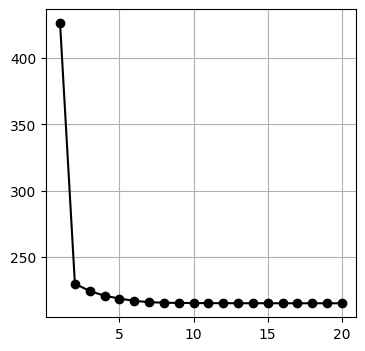

In [ ]:
# ----------------- 리스트 9-2-(15)
Pi = np.array([0.3, 0.3, 0.4])
Mu = np.array([[2, 2], [-2, 0], [2, -2]])
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]


max_it = 20
it = 0
Err = np.zeros(max_it) # distortion measure
for it in range(0, max_it):
    Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)
    Err[it] = nlh_mixgauss(X,Pi,Mu,Sigma)
    Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)


print(np.round(Err, 2))
plt.figure(2, figsize=(4, 4))
plt.plot(np.arange(max_it) + 1,
Err, color='k', linestyle='-', marker='o')
#plt.ylim([40, 80])
plt.grid(True)
plt.show()